# Developing an AI for Hand Gesture Recognition

You are working for a gaming company developing interactive AI-powered games. Your task is to create a hand gesture recognition model to play a game of Rock, Paper, Scissors against human players. The model should be accurate and able to predict gestures from images in real-time.

The Rock, Paper, Scissors dataset, available in TensorFlow Datasets, contains RGB images of hands showing rock, paper, and scissors gestures. Your goal is to create a model using transfer learning and test its real-time application potential.

In [5]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#Added more imports
import numpy as np
import tensorflow as tf
import collections
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Dataset Info: tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemo

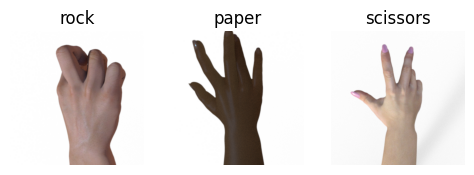

In [6]:
# Load Rock, Paper, Scissors Dataset
dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)

# Split Dataset into Train and Test
train_dataset = dataset['train']
test_dataset = dataset['test']

# Print Dataset Information
print("Dataset Info:", info)
print(f"Number of training examples: {info.splits['train'].num_examples}")
print(f"Number of test examples: {info.splits['test'].num_examples}")
print("Classes:", info.features['label'].names)

# Visualize Sample Images
plt.figure(figsize=(10, 5))
for example in train_dataset.take(10):
    image, label = example
    plt.subplot(2, 5, label.numpy() + 1)
    plt.imshow(image)
    plt.title(info.features['label'].names[label.numpy()])
    plt.axis('off')
plt.show()

In [7]:
# --- 2. Explore the Dataset ---
print("--- Dataset Information ---")
print(f"Dataset Name: {info.name}")
print(f"Dataset Version: {info.version}")
print(f"Description: {info.description}")
print(f"Number of total examples: {info.splits['train'].num_examples + info.splits['test'].num_examples}")
print(f"Number of training examples: {info.splits['train'].num_examples}")
print(f"Number of test examples: {info.splits['test'].num_examples}")
print(f"Classes: {info.features['label'].names}")
print(f"Number of classes: {info.features['label'].num_classes}")
print("---" * 20)

# Number of images per class
class_counts = collections.defaultdict(int)
for _, label in train_dataset:
    class_counts[info.features['label'].names[label.numpy()]] += 1
for _, label in test_dataset:
    class_counts[info.features['label'].names[label.numpy()]] += 1

print("\n--- Number of Images Per Class ---")
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")
print("---" * 20)

# Image dimensions (assuming all images have the same shape after loading)
for image, _ in train_dataset.take(1):
    image_shape = image.numpy().shape
    print("\n--- Image Dimensions ---")
    print(f"Image Height: {image_shape[0]}")
    print(f"Image Width: {image_shape[1]}")
    print(f"Number of Channels: {image_shape[2]}")
    print("---" * 20)
    break

# Data types of features
print("\n--- Data Types of Features ---")
print(f"Feature 'image': Numerical (pixel values, typically uint8)")
print(f"Feature 'label': Categorical (integer encoding)")
print("---" * 20)

--- Dataset Information ---
Dataset Name: rock_paper_scissors
Dataset Version: 3.0.0
Description: Images of hands playing rock, paper, scissor game.
Number of total examples: 2892
Number of training examples: 2520
Number of test examples: 372
Classes: ['rock', 'paper', 'scissors']
Number of classes: 3
------------------------------------------------------------

--- Number of Images Per Class ---
Class 'scissors': 964 images
Class 'rock': 964 images
Class 'paper': 964 images
------------------------------------------------------------

--- Image Dimensions ---
Image Height: 300
Image Width: 300
Number of Channels: 3
------------------------------------------------------------

--- Data Types of Features ---
Feature 'image': Numerical (pixel values, typically uint8)
Feature 'label': Categorical (integer encoding)
------------------------------------------------------------


In [8]:
# Check for missing images or labels in the training dataset
missing_images_train = 0
missing_labels_train = 0
for image, label in train_dataset:
    if image is None:
        missing_images_train += 1
    if label is None:
        missing_labels_train += 1

# Check for missing images or labels in the test dataset
missing_images_test = 0
missing_labels_test = 0
for image, label in test_dataset:
    if image is None:
        missing_images_test += 1
    if label is None:
        missing_labels_test += 1

print(f"Missing images in training dataset: {missing_images_train}")
print(f"Missing labels in training dataset: {missing_labels_train}")
print(f"Missing images in test dataset: {missing_images_test}")
print(f"Missing labels in test dataset: {missing_labels_test}")


Missing images in training dataset: 0
Missing labels in training dataset: 0
Missing images in test dataset: 0
Missing labels in test dataset: 0


In [9]:
print("\n--- Encoding Categorical Features ---")
print(f"Label mapping: {info.features['label'].names} -> [0, 1, 2]")


--- Encoding Categorical Features ---
Label mapping: ['rock', 'paper', 'scissors'] -> [0, 1, 2]


In [10]:
IMG_SIZE = 224
BATCH_SIZE = 32

def augment(image, label):
    """Applies random augmentations to the image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Random rotation
    angle = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)  # Small random rotation
    image = tfa.image.rotate(image, angle)  # Requires TensorFlow Addons (tfa) for rotate

    return image, label


In [11]:
# Create a rotation layer once
rotation_layer = tf.keras.layers.RandomRotation(factor=0.2)

def augment(image, label):
    """Applies random augmentations to the image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Apply random rotation using built-in layer
    image = rotation_layer(image)
    return image, label

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

# Pipeline
train_dataset_augmented = (
    train_dataset
    .map(preprocess)
    .map(augment)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset_processed = (
    test_dataset
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


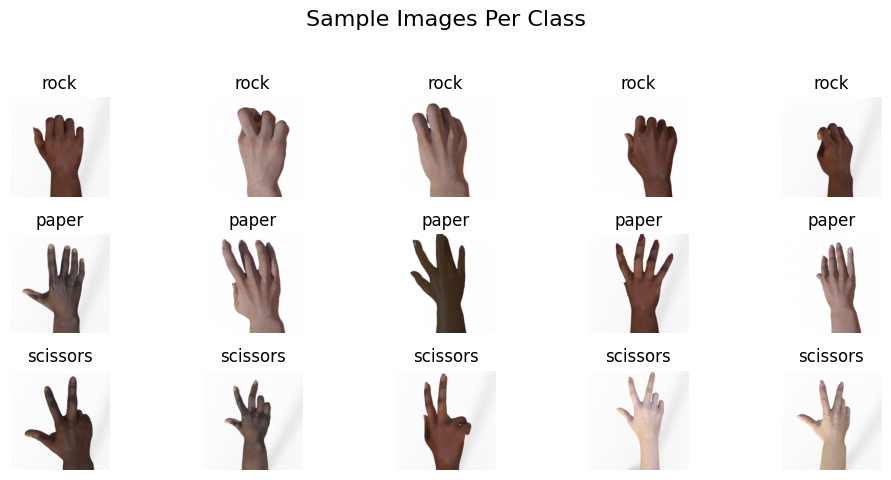

In [12]:
# Visualize sample images for each class
class_names = info.features['label'].names
num_classes = len(class_names)
plt.figure(figsize=(10, 5))
for i, class_index in enumerate(range(num_classes)):
    subset = train_dataset.filter(lambda image, label: label == class_index).take(5)
    for j, (image, label) in enumerate(subset):
        plt.subplot(num_classes, 5, i * 5 + j + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[label.numpy()])
        plt.axis('off')
plt.suptitle("Sample Images Per Class", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
# --- 2. Load the Pre-trained EfficientNetB0 Model (without the top classification layer) ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# --- 3. Freeze the Base Model Layers ---
base_model.trainable = False

# --- 4. Create the Custom Classification Head ---
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# --- 5. Build the Transfer Learning Model ---
model = Model(inputs, outputs)

# --- 6. Compile the Model ---
optimizer = Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False) # Assuming one-hot encoded labels if needed
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- 7. Print Model Summary ---
model.summary()

# --- 8. (Placeholder for Training - Requires your loaded and preprocessed datasets) ---
# EPOCHS = 10
# history = model.fit(train_dataset,
#                     epochs=EPOCHS,
#                     validation_data=test_dataset)

print("\n--- EfficientNetB0 Transfer Learning Pipeline Implemented ---")
print("Model summary printed above.")
print("Remember to load and preprocess your 'train_dataset' and 'test_dataset' before training.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- EfficientNetB0 Transfer Learning Pipeline Implemented ---
Model summary printed above.
Remember to load and preprocess your 'train_dataset' and 'test_dataset' before training.


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - accuracy: 0.6034 - loss: 0.8785 - val_accuracy: 0.9623 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9419 - loss: 0.3476 - val_accuracy: 0.9821 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9693 - loss: 0.2067 - val_accuracy: 0.9861 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9841 - loss: 0.1468 - val_accuracy: 0.9940 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9874 - loss: 0.1107 - val_accuracy: 0.9921 - val_loss: 0.0807 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9905 - loss: 0.1037 - val_accuracy: 0.9960 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9929 - loss: 0.0835 - val_a

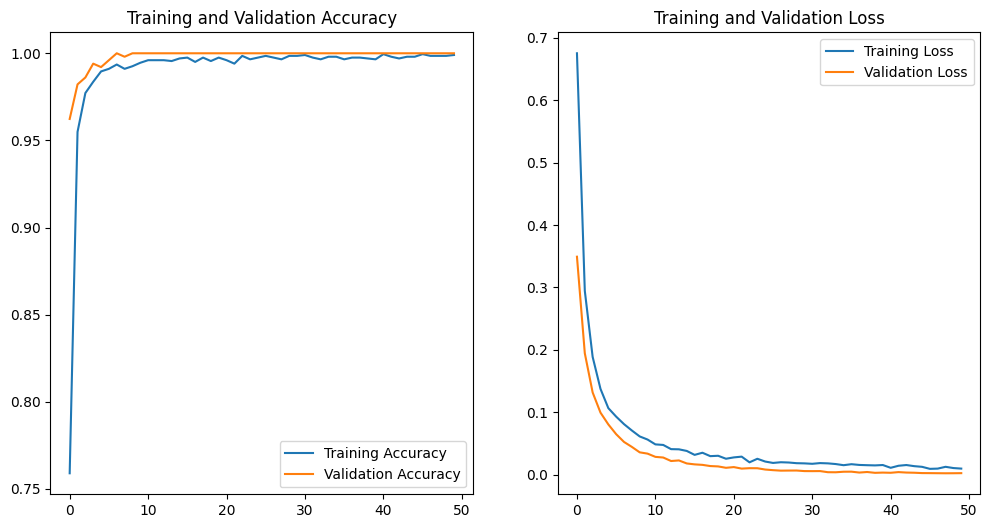


--- Model Training Completed ---


In [14]:
num_classes = 3

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, tf.one_hot(label, depth=num_classes) # One-hot encode labels

dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
train_val_dataset = dataset['train'].map(preprocess).cache()
test_dataset = dataset['test'].map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Split train_val_dataset into training and validation sets
train_examples = int(info.splits['train'].num_examples * 0.8)
validation_examples = info.splits['train'].num_examples - train_examples

train_dataset = train_val_dataset.take(train_examples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = train_val_dataset.skip(train_examples).take(validation_examples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- 2. Load the Pre-trained EfficientNetB0 Model ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# --- 3. Create the Custom Classification Head ---
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# --- 4. Compile the Model ---
optimizer = Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- 5. Define Callbacks for Overfitting/Underfitting ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
callbacks = [early_stopping, reduce_lr]

# --- 6. Train the Model ---
EPOCHS = 50
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)

# --- 7. Evaluate the Model on the Test Set ---
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- 8. Visualize Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("\n--- Model Training Completed ---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


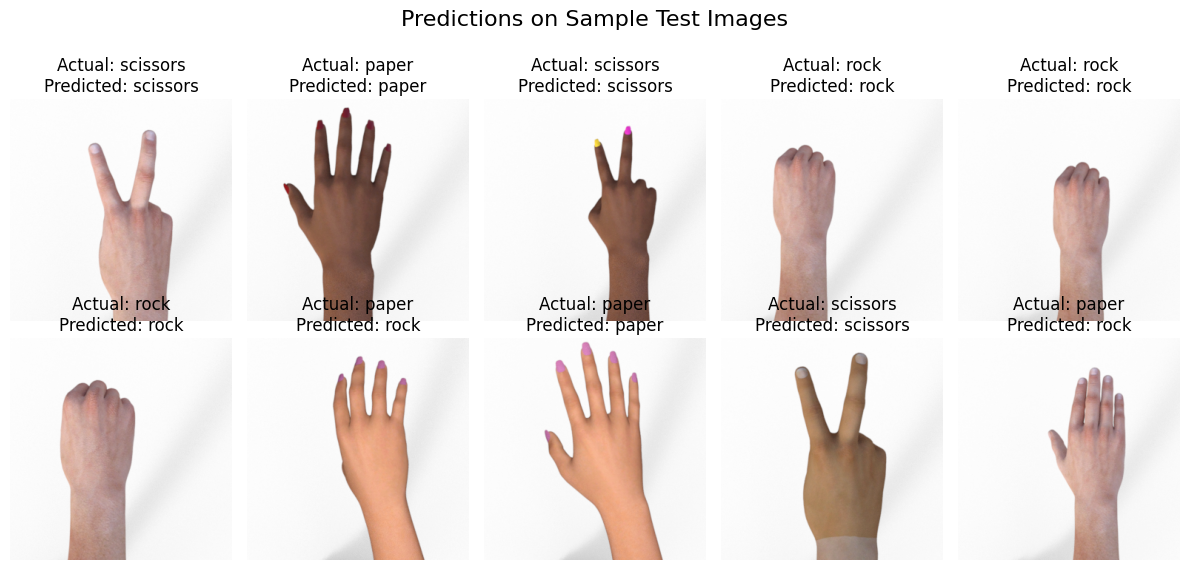


Trained model saved as 'rock_paper_scissors_model.h5'

Prediction for 'rock_image.jpg': Error processing image: [Errno 2] No such file or directory: 'rock_image.jpg'
Prediction for 'paper_image.jpg': Error processing image: [Errno 2] No such file or directory: 'paper_image.jpg'
Prediction for 'scissors_image.jpg': Error processing image: [Errno 2] No such file or directory: 'scissors_image.jpg'


In [15]:
class_names = ['rock', 'paper', 'scissors']

def preprocess_predict(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = np.expand_dims(image.numpy(), axis=0) # Add batch dimension
    return image

dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
test_dataset_raw = dataset['test']

# --- 3. Make Predictions on the Test Set ---
predictions = []
test_labels = []
test_images_for_vis = []
num_samples_to_visualize = 10

for i, (image, label) in enumerate(test_dataset_raw.take(num_samples_to_visualize)):
    processed_image = preprocess_predict(image)
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction)
    predictions.append(predicted_class_index)
    test_labels.append(label.numpy())
    test_images_for_vis.append(image.numpy())

plt.figure(figsize=(12, 6))
for i in range(num_samples_to_visualize):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images_for_vis[i])
    plt.title(f"Actual: {class_names[test_labels[i]]}\nPredicted: {class_names[predictions[i]]}")
    plt.axis('off')
plt.suptitle("Predictions on Sample Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 4. Save the Trained Model ---
model.save('rock_paper_scissors_model.h5')
print("\nTrained model saved as 'rock_paper_scissors_model.h5'")

# --- 5. Create a Prediction Function for New Image Inputs ---
def predict_gesture(image_path):
    """
    Accepts the path to a new image, preprocesses it, and predicts the gesture label.
    Args:
        image_path (str): Path to the image file.
    Returns:
        str: The predicted gesture label ('rock', 'paper', or 'scissors').
    """
    try:
        img = tf.keras.utils.load_img(image_path)
        img_array = tf.keras.utils.img_to_array(img)
        processed_img = preprocess_predict(img_array)
        prediction = model.predict(processed_img)
        predicted_class_index = np.argmax(prediction)
        return class_names[predicted_class_index]
    except Exception as e:
        return f"Error processing image: {e}"

# --- 6. Example Usage of the Prediction Function ---
# You would replace 'path/to/your/new_image.jpg' with the actual path to an image file
new_image_path_rock = 'rock_image.jpg' # Replace with a path to a rock image
new_image_path_paper = 'paper_image.jpg' # Replace with a path to a paper image
new_image_path_scissors = 'scissors_image.jpg' # Replace with a path to a scissors image

try:
    prediction_rock = predict_gesture(new_image_path_rock)
    print(f"\nPrediction for '{new_image_path_rock}': {prediction_rock}")

    prediction_paper = predict_gesture(new_image_path_paper)
    print(f"Prediction for '{new_image_path_paper}': {prediction_paper}")

    prediction_scissors = predict_gesture(new_image_path_scissors)
    print(f"Prediction for '{new_image_path_scissors}': {prediction_scissors}")

except FileNotFoundError:
    print("\nMake sure the example image paths are correct.")
except Exception as e:
    print(f"\nAn error occurred during prediction example: {e}")

In [16]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, tf.one_hot(label, depth=num_classes)

dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
train_val_dataset = dataset['train'].map(preprocess).cache()

# Split train_val_dataset into training and validation sets
train_examples = int(info.splits['train'].num_examples * 0.8)
validation_examples = info.splits['train'].num_examples - train_examples

train_dataset = train_val_dataset.take(train_examples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = train_val_dataset.skip(train_examples).take(validation_examples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- 2. Define the Model Creation Function (to easily try different hyperparameters) ---
def create_model(learning_rate=0.001, dropout_rate=0.5):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    metrics = ['accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# --- 3. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
callbacks = [early_stopping, reduce_lr]

# --- 4. Train with Different Learning Rates ---
learning_rates_to_try = [0.001, 0.0001]
histories = {}

for lr in learning_rates_to_try:
    print(f"\n--- Training with Learning Rate: {lr} ---")
    model = create_model(learning_rate=lr)
    history = model.fit(
        train_dataset,
        epochs=30, # Reduced epochs for demonstration
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=0 # Suppress per-epoch output for brevity
    )
    histories[lr] = history

# --- 5. Evaluate and Compare Results ---
print("\n--- Evaluation on Test Set ---")
best_lr = None
best_accuracy = 0.0

for lr, history in histories.items():
    model = create_model(learning_rate=lr) # Re-load the model with the specific LR
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"Learning Rate: {lr}, Test Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr = lr

print(f"\nBest Learning Rate found (manual exploration): {best_lr} with Test Accuracy: {best_accuracy:.4f}")


--- Training with Learning Rate: 0.001 ---

--- Training with Learning Rate: 0.0001 ---

--- Evaluation on Test Set ---
Learning Rate: 0.001, Test Accuracy: 0.1855
Learning Rate: 0.0001, Test Accuracy: 0.3280

Best Learning Rate found (manual exploration): 0.0001 with Test Accuracy: 0.3280


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

--- Model Evaluation ---
Accuracy: 0.3280

Classification Report:
              precision    recall  f1-score   support

        rock       0.33      0.02      0.03       124
       paper       0.44      0.97      0.60       124
    scissors       0.00      0.00      0.00       124

    accuracy                           0.33       372
   macro avg       0.26      0.33      0.21       372
weighted avg       0.26      0.33      0.21       372


Confusion Matrix:
[[  2  31  91]
 [  4 120   0]
 [  0 124   0]]


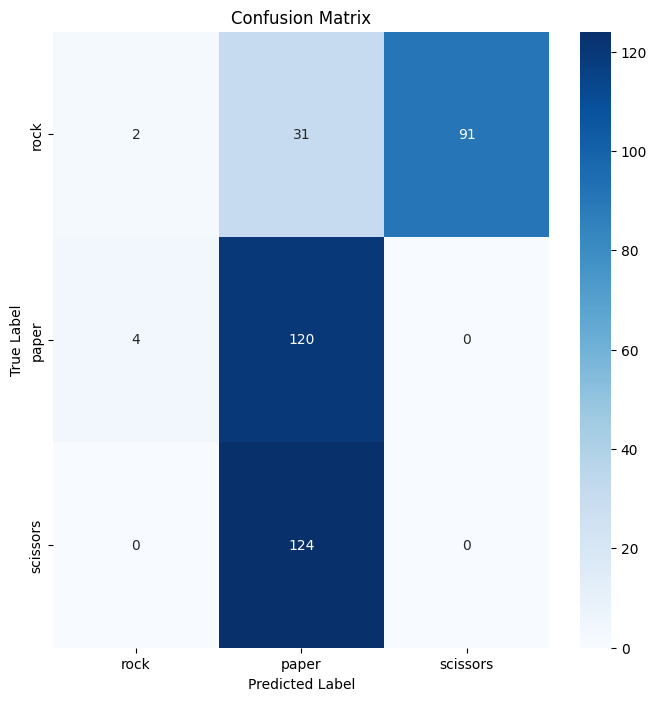

In [17]:
class_names = ['rock', 'paper', 'scissors']

def preprocess_eval(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
test_dataset = dataset['test'].map(preprocess_eval).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_no_batch = dataset['test'].map(preprocess_eval)

# --- 3. Make Predictions on the Test Set ---
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# --- 4. Evaluate Performance Metrics ---
print("\n--- Model Evaluation ---")

# a) Accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Accuracy: {accuracy:.4f}")

# b) Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# c) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# --- 5. Visualize Confusion Matrix ---
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [18]:
!pip install keras-tuner -q
from keras_tuner import RandomSearch

In [19]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, tf.one_hot(label, depth=num_classes)

dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
train_val_dataset = dataset['train'].map(preprocess).cache()
train_examples = int(info.splits['train'].num_examples * 0.8)
validation_examples = info.splits['train'].num_examples - train_examples
train_dataset = train_val_dataset.take(train_examples).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = train_val_dataset.skip(train_examples).take(validation_examples).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# --- 2. Define the Model Building Function for Keras Tuner ---
def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = Adam(learning_rate=lr)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    metrics = ['accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# --- 3. Initialize the Tuner ---
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, # Adjust based on time and resources
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='rps_tuning'
)

# --- 4. Perform the Hyperparameter Search ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(train_dataset,
             epochs=10, # Adjust based on time
             validation_data=validation_dataset,
             callbacks=[early_stopping])

# --- 5. Get the Best Hyperparameters and Model ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"\nBest Hyperparameters found: {best_hps}")

# --- 6. Evaluate the Best Model on the Test Set ---
loss, accuracy = best_model.evaluate(test_dataset, verbose=1)
print(f"\nBest Model Test Loss: {loss:.4f}")
print(f"Best Model Test Accuracy: {accuracy:.4f}")

Trial 5 Complete [00h 01m 15s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 17m 03s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Best Hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7ea65c9e8810>
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.7266 - loss: 0.4980

Best Model Test Loss: 0.5217
Best Model Test Accuracy: 0.7124


In [20]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, tf.one_hot(label, depth=num_classes)

dataset, info = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
train_val_dataset = dataset['train'].map(preprocess).cache()
train_examples = int(info.splits['train'].num_examples * 0.8)
validation_examples = info.splits['train'].num_examples - train_examples
train_dataset = train_val_dataset.take(train_examples).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = train_val_dataset.skip(train_examples).take(validation_examples).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# --- 2. Define the Model Building Function for Keras Tuner ---
def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = Adam(learning_rate=lr)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    metrics = ['accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# --- 3. Initialize the Tuner ---
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, # Adjust based on time and resources
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='rps_tuning'
)

# --- 4. Perform the Hyperparameter Search ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(train_dataset,
             epochs=10, # Adjust based on time
             validation_data=validation_dataset,
             callbacks=[early_stopping])

# --- 5. Get the Best Hyperparameters and Model ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"\nBest Hyperparameters found: {best_hps}")

# --- 6. Evaluate the Best Model on the Test Set ---
loss, accuracy = best_model.evaluate(test_dataset, verbose=1)
print(f"\nBest Model Test Loss: {loss:.4f}")
print(f"Best Model Test Accuracy: {accuracy:.4f}")

Reloading Tuner from tuner_dir/rps_tuning/tuner0.json

Best Hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7ea653afd310>
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 527ms/step - accuracy: 0.7314 - loss: 0.5323

Best Model Test Loss: 0.5564
Best Model Test Accuracy: 0.7177
